# Imports

In [ ]:
!pip install opencv-python-headless

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)


2.15.0
2.15.0


In [3]:
import os
import shutil
import numpy as np
import cv2
import random
import warnings
from google.colab import drive
import tensorflow as tf
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## Blur, darken and augment photos

In [5]:
def random_blur(image): # blur the images
    ksize = np.random.choice(range(5, 35, 2))
    image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return image

def random_darken(image): # darken the images
    factor = np.random.uniform(0.3, 0.7)
    image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return image

def distort_image(image): # Randomly decide to blur or darken
    if np.random.rand() > 0.5:
        image = random_blur(image)
    else:
        image = random_darken(image)
    return image

def random_augmentation(image): # augment the dataset with flips, rotation and contrast adjust for improving our results
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image

In [6]:
### Prepare the input data

In [7]:
def process_path(image_path):
    image_path = image_path.numpy().decode('utf-8')
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # distortions
    distorted_image = distort_image(original_image.copy())

    # resize to 256x256
    original_image = cv2.resize(original_image, (256, 256))
    distorted_image = cv2.resize(distorted_image, (256, 256))

    # normalize
    original_image = original_image / 255.0
    distorted_image = distorted_image / 255.0

    return distorted_image.astype(np.float32), original_image.astype(np.float32)

def tf_process_path(image_path):
    distorted_image, original_image = tf.py_function(process_path, [image_path], [tf.float32, tf.float32])
    distorted_image.set_shape([256, 256, 3])
    original_image.set_shape([256, 256, 3])
    return distorted_image, original_image

def load_dataset(image_dir, batch_size=16):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(tf_process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths) * 2)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dir = '/content/drive/My Drive/Unblur-and-improve-your-pictures-/train'
validation_dir = '/content/drive/My Drive/Unblur-and-improve-your-pictures-/val'

train_dataset = load_dataset(train_dir, batch_size=16)
validation_dataset = load_dataset(validation_dir, batch_size=16)

In [8]:
print(len(train_dataset), len(validation_dataset))

65 20


# UNet Architecture

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

## First Try

In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # decoder
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

checkpoint_path = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/models/checkpoint_unet_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

model = unet_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=50, batch_size=16, validation_data=validation_dataset)

Epoch 1/50
65/65 [==============================] - 202s 798ms/step - loss: 0.0385 - accuracy: 0.6133 - val_loss: 0.0205 - val_accuracy: 0.7796
Epoch 2/50
65/65 [==============================] - 117s 605ms/step - loss: 0.0210 - accuracy: 0.7523 - val_loss: 0.0178 - val_accuracy: 0.8383
Epoch 3/50
65/65 [==============================] - 119s 601ms/step - loss: 0.0224 - accuracy: 0.7477 - val_loss: 0.0172 - val_accuracy: 0.8134
Epoch 4/50
65/65 [==============================] - 115s 588ms/step - loss: 0.0190 - accuracy: 0.7923 - val_loss: 0.0168 - val_accuracy: 0.8462
Epoch 5/50
65/65 [==============================] - 118s 593ms/step - loss: 0.0230 - accuracy: 0.7636 - val_loss: 0.0229 - val_accuracy: 0.7377
Epoch 6/50
65/65 [==============================] - 116s 607ms/step - loss: 0.0196 - accuracy: 0.7852 - val_loss: 0.0188 - val_accuracy: 0.8048
Epoch 7/50
65/65 [==============================] - 117s 596ms/step - loss: 0.0182 - accuracy: 0.7982 - val_loss: 0.0196 - val_accuracy:

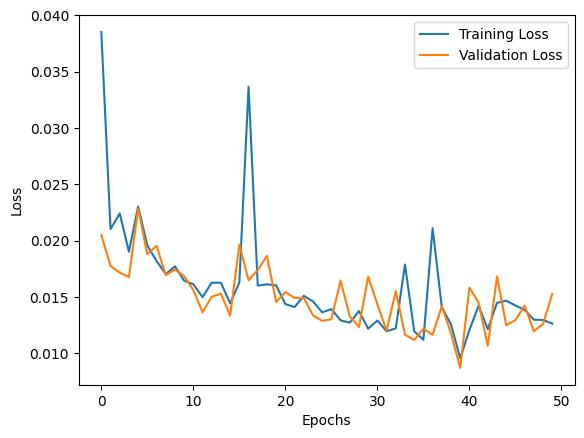

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Second Try

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # decoder
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model = unet_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy', tf.keras.metrics.MeanSquaredError()])

In [12]:
checkpoint_path = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/checkpoints/checkpoint_unet_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(train_dataset, epochs=45, batch_size=16, validation_data=validation_dataset, callbacks=[checkpoint])

model_path = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/models/final_unet_model.h5"
model.save(model_path)

Epoch 1/45
65/65 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.7216 - mean_squared_error: 0.0183
Epoch 1: val_loss improved from inf to 0.01472, saving model to /content/drive/My Drive/Unblur-and-improve-your-pictures-/checkpoints/checkpoint_unet_model.h5
65/65 [==============================] - 121s 616ms/step - loss: 0.0183 - accuracy: 0.7216 - mean_squared_error: 0.0183 - val_loss: 0.0147 - val_accuracy: 0.8223 - val_mean_squared_error: 0.0147
Epoch 2/45
65/65 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.7509 - mean_squared_error: 0.0147
Epoch 2: val_loss improved from 0.01472 to 0.01321, saving model to /content/drive/My Drive/Unblur-and-improve-your-pictures-/checkpoints/checkpoint_unet_model.h5
65/65 [==============================] - 122s 671ms/step - loss: 0.0147 - accuracy: 0.7509 - mean_squared_error: 0.0147 - val_loss: 0.0132 - val_accuracy: 0.8036 - val_mean_squared_error: 0.0132
Epoch 3/45
65/65 [========================

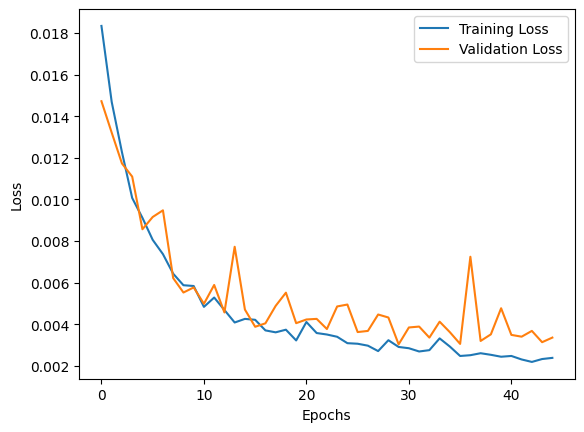

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## TESTING HERE

In [14]:
model_path = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/models/final_backup_unet_model.h5"
model.save(model_path)

In [21]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os

def pad_image(image, target_size=(256, 256)):
    old_size = image.shape[:2]  # original size
    ratio = float(target_size[0])/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be within the target size
    image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_image, top, bottom, left, right

def unpad_image(image, top, bottom, left, right):
    height, width = image.shape[:2]
    return image[top:height-bottom, left:width-right]

def restore_images(input_folder, output_folder, model_path):
    # Load the trained model
    print(f"Loading model from: {model_path}")
    model_unet = load_model(model_path)

    # Loop through all images in the input folder
    for image_name in os.listdir(input_folder):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_image_path = os.path.join(input_folder, image_name)
            output_image_path = os.path.join(output_folder, image_name)

            # Load and preprocess the image
            image = cv2.imread(input_image_path)
            padded_image, top, bottom, left, right = pad_image(image)
            normalized_image = padded_image / 255.0  # Normalize the image
            expanded_image = np.expand_dims(normalized_image, axis=0)  # Add batch dimension

            # Run prediction
            restored_image = model_unet.predict(expanded_image)

            # Post-process the restored image
            restored_image = np.clip(restored_image[0] * 255, 0, 255).astype(np.uint8)
            restored_image = unpad_image(restored_image, top, bottom, left, right)  # Remove padding

            # Save the restored image
            cv2.imwrite(output_image_path, restored_image)

    print("Restoration process finished for all images in the input folder!")

# Set these paths to your actual directories
input_folder = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/TEST_INPUT"
output_folder = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/TEST_OUTPUT"
model_path = "/content/drive/My Drive/Unblur-and-improve-your-pictures-/models/final_unet_model.h5"

restore_images(input_folder, output_folder, model_path)

Loading model from: /content/drive/My Drive/Unblur-and-improve-your-pictures-/models/final_unet_model.h5
1/1 [==============================] - 0s 21ms/step
Restoration process finished for all images in the input folder!
